In [5]:
!pip install kaggle

In [6]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [7]:
!kaggle competitions download -c dogs-vs-cats

 99% 802M/812M [00:09<00:00, 116MB/s]
100% 812M/812M [00:09<00:00, 90.7MB/s]


In [8]:
from zipfile import ZipFile

dataset = '/content/dogs-vs-cats.zip'

with ZipFile(dataset,'r') as zip:
  zip.extractall()

In [9]:
from zipfile import ZipFile

dataset = '/content/train.zip'

with ZipFile(dataset,'r') as zip:
  zip.extractall()

In [10]:
import os

path,dir,files = next(os.walk('/content/train'))

count = len(files)
print("number of images : ",count)

number of images :  25000


In [11]:
filename = os.listdir('/content/train')
print(filename)

['dog.8949.jpg', 'dog.12294.jpg', 'dog.77.jpg', 'cat.5752.jpg', 'dog.3477.jpg', 'dog.8042.jpg', 'dog.1385.jpg', 'dog.70.jpg', 'cat.9207.jpg', 'dog.9390.jpg', 'cat.2213.jpg', 'cat.4420.jpg', 'cat.6124.jpg', 'dog.7898.jpg', 'dog.3535.jpg', 'dog.9616.jpg', 'cat.3933.jpg', 'dog.7801.jpg', 'cat.6829.jpg', 'cat.3882.jpg', 'cat.9729.jpg', 'cat.11968.jpg', 'dog.4219.jpg', 'cat.9005.jpg', 'cat.5220.jpg', 'cat.58.jpg', 'cat.1671.jpg', 'cat.6780.jpg', 'cat.6987.jpg', 'dog.11278.jpg', 'cat.11906.jpg', 'dog.421.jpg', 'cat.3362.jpg', 'cat.10690.jpg', 'cat.2913.jpg', 'dog.3546.jpg', 'dog.10669.jpg', 'dog.3425.jpg', 'cat.9539.jpg', 'dog.6592.jpg', 'dog.12058.jpg', 'cat.5503.jpg', 'cat.8091.jpg', 'cat.963.jpg', 'cat.9800.jpg', 'cat.11868.jpg', 'cat.3553.jpg', 'dog.6074.jpg', 'dog.11456.jpg', 'cat.5754.jpg', 'cat.4460.jpg', 'cat.5243.jpg', 'dog.9365.jpg', 'cat.8360.jpg', 'cat.5546.jpg', 'dog.3835.jpg', 'dog.3457.jpg', 'dog.2776.jpg', 'cat.9765.jpg', 'cat.4433.jpg', 'cat.11320.jpg', 'cat.8037.jpg', 'dog.

In [12]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
from google.colab.patches import cv2_imshow

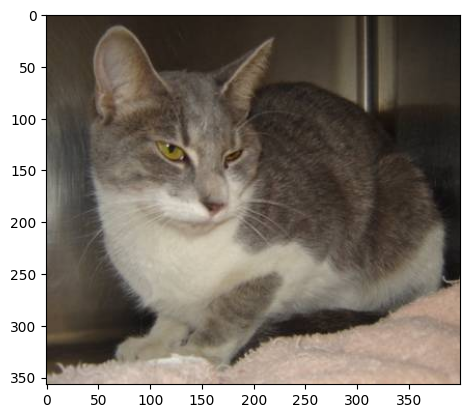

In [13]:
img = mpimg.imread('/content/train/cat.4352.jpg')
plt.imshow(img)

In [14]:
filename = os.listdir('/content/train')
dog = 0
cat = 0
for i in range(len(filename)):
  name = filename[i]
  x = name[0:3]
  if x == 'dog':
    dog += 1
  else:
    cat+=1

print("number of dog images : ",dog)
print("number of cat images : ",cat)

number of dog images :  12500
number of cat images :  12500


**Image Preprocessing**

In [15]:
os.mkdir('/content/resized image')

In [18]:
original_file = '/content/train/'
resized_file = '/content/resized image/'

for i in range(2000):
  filename = os.listdir(original_file)[i]
  img_path = original_file + filename

  img = Image.open(img_path)
  img = img.resize((224,224))
  img = img.convert('RGB')

  newimgpath = resized_file + filename
  img.save(newimgpath)

Dog -> 1
Cat -> 0

In [28]:
filename = os.listdir('/content/train')
labels = []
for i in range(2000):
  name = filename[i]
  x = name[0:3]
  if x == 'dog':
    labels.append(1)
  else:
    labels.append(0)


In [29]:
print(filename[0:5])

['dog.8949.jpg', 'dog.12294.jpg', 'dog.77.jpg', 'cat.5752.jpg', 'dog.3477.jpg']


In [30]:
print(labels[0:5])

[1, 1, 1, 0, 1]


In [31]:
dog_count = 0
cat_count = 0

for i in labels:
  if i == 0:
    cat_count += 1
  else:
    dog_count += 1

print("number of dog images : ",dog_count)
print("number of cat images : ",cat_count)


number of dog images :  1014
number of cat images :  986


In [32]:
import cv2
import glob

In [38]:
image_directory = '/content/resized image/'
image_extension = ['png','jpg']

files = []
[files.extend(glob.glob(image_directory + '*.' + e)) for e in image_extension]

dog_cat_images = np.asarray([cv2.imread(file) for file in files])

In [39]:
print(dog_cat_images.shape)

(2000, 224, 224, 3)


In [40]:
X = dog_cat_images
Y = np.asarray(labels)

In [41]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size = 0.2,random_state=2)

In [42]:
X_train_scaled = X_train/255
X_test_scaled = X_test/255

Building the neural network

In [43]:
import tensorflow as tf
import tensorflow_hub as hub

In [46]:
mobilenet_model = 'https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4'

pretrained_model = hub.KerasLayer(mobilenet_model, input_shape = (224,224,3), trainable = False)

In [48]:
num_of_classes = 2

model = tf.keras.Sequential([
    pretrained_model,
    tf.keras.layers.Dense(num_of_classes)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense_1 (Dense)             (None, 2)                 2562      
                                                                 
Total params: 2260546 (8.62 MB)
Trainable params: 2562 (10.01 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [49]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics = ['acc']
)

In [51]:
model.fit(X_train_scaled,Y_train,epochs = 5)

Epoch 1/5
50/50 [==============================] - 10s 40ms/step - loss: 0.1881 - acc: 0.9287
Epoch 2/5
50/50 [==============================] - 2s 40ms/step - loss: 0.0648 - acc: 0.9781
Epoch 3/5
50/50 [==============================] - 2s 40ms/step - loss: 0.0483 - acc: 0.9850
Epoch 4/5
50/50 [==============================] - 2s 40ms/step - loss: 0.0397 - acc: 0.9919
Epoch 5/5
50/50 [==============================] - 2s 41ms/step - loss: 0.0313 - acc: 0.9931


In [52]:
score, acc = model.evaluate(X_test_scaled, Y_test)
print('Test Loss =', score)
print('Test Accuracy =', acc)

13/13 [==============================] - 3s 126ms/step - loss: 0.0648 - acc: 0.9750
Test Loss = 0.06477776169776917
Test Accuracy = 0.9750000238418579


Path of the image to be predicted: /content/cat.jpg


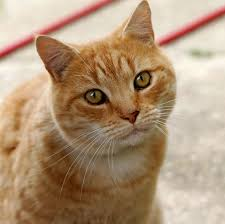

1/1 [==============================] - 0s 35ms/step
[[ 5.170514 -4.193433]]
0
The image represents a Cat


In [54]:
input_image_path = input('Path of the image to be predicted: ')

input_image = cv2.imread(input_image_path)

cv2_imshow(input_image)

input_image_resize = cv2.resize(input_image, (224,224))

input_image_scaled = input_image_resize/255

image_reshaped = np.reshape(input_image_scaled, [1,224,224,3])

input_prediction = model.predict(image_reshaped)

print(input_prediction)

input_pred_label = np.argmax(input_prediction)

print(input_pred_label)

if input_pred_label == 0:
  print('The image represents a Cat')

else:
  print('The image represents a Dog')